In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**What is customer churn?**

Customers churn when they terminate services with a company. In the context of Banking, customers churn when they stop using the services provided by the bank. Reasons for churn:


*   They simply no longer use their services
*   They go to Bank's competitors


**Part 1 - Data Preprocessing**

In [0]:
#!pip install pyforest
#from pyforest import *

In [0]:
# Importing needed libraries
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import mannwhitneyu

from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

**Setting up plotly function**

In [0]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
  import plotly.graph_objs as go
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=True)

In [0]:
# Importing the dataset
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Churn_Modelling.csv')

In [6]:
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


We define some functions which will perform the crux of the Hypothesis testing in this notebook

In [0]:
def is_normal(group):
    """Check if input ndarray is normally distributed using the Shapiro Wilk Test"""
    wval, pval = stats.shapiro(group)
    if len(group) > 5000: # W-stat is more accurate for larger sample sizes
        if wval < 0.05: return False
    if pval < 0.05: return False
    return True

def has_eq_var(group_1, group_2):
    """Check the property of homoscendacity (equal variance) using the Levene test"""
    _, pval = stats.levene(group_1, group_2) 
    if pval < 0.05: return False
    return True

def stat_test(group_1, group_2):
    """Between 2 groups, if the conditions of normality + homoscendacity hold, perform 
    T-Test, otherwise perform the Mann Whiteny U Test."""
    if is_normal(group_1) and is_normal(group_2):
        if has_eq_var(group_1, group_2): 
            print("Performing T-Test ...")
            return stats.ttest_ind(group_1, group_2)
        print("Performing T-Test with unequal variance ...")
        return stats.ttest_ind(group_1, group_2, equal_var=False)
    print("Performing U-Test ...")
    return mannwhitneyu(group_1, group_2)

**1. Active Vs Churned Stats**

In [0]:
active_users = dataset[dataset['Exited']==0]
churned_users = dataset[dataset['Exited']==1]

active_male_users = active_users[active_users['Gender']=='Male']
churned_male_users = churned_users[churned_users['Gender']=='Male']

active_female_users = active_users[active_users['Gender']=='Female']
churned_female_users = churned_users[churned_users['Gender']=='Female']

In [9]:
enable_plotly_in_cell()
import plotly.graph_objs as go
from plotly.offline import iplot

labels_active = ['Male','Female']
values_active = [
    active_users[active_users['Gender']=='Male'].shape[0],
    active_users[active_users['Gender']=='Female'].shape[0],
                ]

trace_active = go.Pie(labels=labels_active, values=values_active, hole = .45, 
                      domain={"x": [0, .48]}, hoverinfo='label+percent+value')

labels_churned = ['Male','Female']
values_churned = [
    churned_users[churned_users['Gender']=='Male'].shape[0],
    churned_users[churned_users['Gender']=='Female'].shape[0],
                ]

trace_churned = go.Pie(labels=labels_churned, values=values_churned, hole = .5,
                       domain={"x": [0.52, 1]}, hoverinfo='label+percent+value')

layout={
    'title': 'Gender proportion for Active and Churned users',
    'annotations': [
        {'text': 'Active Users',                
         "x": 0.145, # Position of Text
         "y": 0.5,
         'showarrow':False,
         'font':{'size': 18}
        }, 
        {'text': 'Churned Users',
         "x": 0.875,
        "y": 0.5,
        'showarrow':False,
        'font':{'size': 18}
        }
    ]
}

fig = go.Figure(dict(data=[trace_active, trace_churned], layout=layout))
iplot(fig)

**Observation:**

*   Females make up the largest proportion (56%) of those who have exited the bank. 

**Geographical Customers (Active Vs Churned)**

In [10]:
enable_plotly_in_cell()
import plotly.graph_objs as go
from plotly.offline import iplot

labels_active = ['France','Spain', 'Germany']
values_active = [
    active_users[active_users['Geography']=='France'].shape[0],
    active_users[active_users['Geography']=='Spain'].shape[0],
    active_users[active_users['Geography']=='Germany'].shape[0]
                ]

trace_active = go.Pie(labels=labels_active, values=values_active, hole = .45, 
                      domain={"x": [0, .48]}, hoverinfo='label+percent+value')

labels_churned = ['France','Spain', 'Germany']
values_churned = [
    churned_users[churned_users['Geography']=='France'].shape[0],
    churned_users[churned_users['Geography']=='Spain'].shape[0],
    churned_users[churned_users['Geography']=='Germany'].shape[0]
                ]

trace_churned = go.Pie(labels=labels_churned, values=values_churned, hole = .50,
                       domain={"x": [0.52, 1]}, hoverinfo='label+percent+value')

layout={
    'title': 'Geographical stats for Active and Churned users',
    'annotations': [
        {'text': 'Active Users',                
         "x": 0.14, # Position of Text
         "y": 0.5,
         'showarrow':False,
         'font':{'size': 18}
        }, 
        {'text': 'Churned Users',
         "x": 0.88,
        "y": 0.5,
        'showarrow':False,
        'font':{'size': 18}
        }
    ]
}

fig = go.Figure(dict(data=[trace_active, trace_churned], layout=layout))
iplot(fig)

**Observation:**


> Customers in Germany and France constitute the largest proportion (40%) of customers who exit the bank. 


**1.2 France Tenure stats (Active vs Churned)**

In [11]:
active_france_users = active_users[active_users['Geography']=='France']
churned_france_users = churned_users[churned_users['Geography']=='France']

enable_plotly_in_cell()
import plotly.graph_objs as go
from plotly.offline import iplot

group_1 = go.Box(
    x=active_france_users['Tenure'],
    name="Active")

group_2 = go.Box(
    x=churned_france_users['Tenure'],
    name="Churned")

info = [group_1, group_2]
title = "Lifetime of Active Vs Churned France Customers"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [12]:
group_1 = active_france_users['Tenure']
group_2 = churned_france_users['Tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=1699669.5, pvalue=0.46868482201524836)

**Observation:** 
    
The U-Test failed to reject the null hypothesis that the 2 groups(Active and Churned) France customers come from the same distribution. Hence, France customers have no significant effect on their tenure with us.

**1.3 Spain Tenure stats (Active vs Churned)**

In [0]:
active_spain_users = active_users[active_users['Geography']=='Spain']
churned_spain_users = churned_users[churned_users['Geography']=='Spain']

In [14]:
enable_plotly_in_cell()
#import plotly.graph_objs as go
#from plotly.offline import iplot

group_1=go.Box(
    x=active_spain_users['Tenure'], name="Active")
group_2 = go.Box(
    x=churned_spain_users['Tenure'],
    name="Churned")

info = [group_1, group_2]
title = "Lifetime of Active Vs Churned Spain Customers"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [15]:
group_1 = active_spain_users['Tenure']
group_2 = churned_spain_users['Tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=388087.5, pvalue=0.001939485369542081)

**Observation:**

Active Spain customers stayed slightly longer with us than Churned customers from same country.

**1.4 Germany Tenure stats (Active vs Churned)**

In [0]:
active_germany_users = active_users[active_users['Geography']=='Germany']
churned_germany_users = churned_users[churned_users['Geography']=='Germany']

In [17]:
enable_plotly_in_cell()
#import plotly.graph_objs as go
#from plotly.offline import iplot

group_1=go.Box(
    x=active_germany_users['Tenure'], name="Active")
group_2 = go.Box(
    x=churned_germany_users['Tenure'],
    name="Churned")

info = [group_1, group_2]
title = "Lifetime of Active Vs Churned Germany Customers"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

In [18]:
group_1 = active_germany_users['Tenure']
group_2 = churned_germany_users['Tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=688994.0, pvalue=0.4794680464042427)

**Observation:** 
    
The U-Test failed to reject the null hypothesis that the 2 groups(Active and Churned) Germany customers come from the same distribution. Hence, Germany customers have no significant effect on their tenure with us.

**1.5 Geographical Tenure stats for Churned customers**

In [19]:
enable_plotly_in_cell()
#import plotly.graph_objs as go
#from plotly.offline import iplot

group_1=go.Box(
    x=churned_germany_users['Tenure'], name="Germany")
group_2 = go.Box(
    x=churned_spain_users['Tenure'],
    name="Spain")
group_3 = go.Box(
    x=churned_france_users['Tenure'],
    name="France")

info = [group_1, group_2,group_3 ]
title = "Lifetime of Churned Geographical Customers"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
     })

**1.6 Male Tenure stats (Active vs Churned)**

In [20]:
enable_plotly_in_cell()
group_1=go.Box(x=active_male_users['Tenure'], name="Active")
group_2 = go.Box(
    x=churned_male_users['Tenure'],
    name="Churned")

info = [group_1, group_2]
title = "Lifetime of Active Vs Churned Male Customers"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
       })

In [21]:
group_1 = active_male_users['Tenure']
group_2 = churned_male_users['Tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=1989853.5, pvalue=0.09166640235084317)

**1.7 Female Tenure stats (Active vs Churned)**

In [22]:
enable_plotly_in_cell()
group_1=go.Box(x=active_female_users['Tenure'], name="Active")
group_2 = go.Box(
    x=churned_female_users['Tenure'],
    name="Churned")

info = [group_1, group_2]
title = "Lifetime of Active Vs Churned female Customers"
iplot({
            "data": info, 
            "layout": {
                "title": title
            }
       })

In [23]:
group_1 = active_female_users['Tenure']
group_2 = churned_female_users['Tenure']
stat_test(group_1, group_2)

Performing U-Test ...


MannwhitneyuResult(statistic=1920709.5, pvalue=0.3197071731996433)

**Gender tenure observation:**

The tenure length of either male or female customers seems not to have significant effect on their churn with us.

**1.8 Number of Products stats(Active vs Churned)**

In [24]:
active_users_products = active_users.NumOfProducts.value_counts()
churned_users_products = churned_users.NumOfProducts.value_counts()

enable_plotly_in_cell()
products=['1_product', '2_products', '3_products', '4_products']
fig = go.Figure(data=[
    go.Bar(name='Active_customers', y=active_users_products, x=products),
    go.Bar(name='Churned_customers', y=churned_users_products, x=products)
])
iplot(fig)

**Observations:**

*   By providing one or two products tends to have significantly more Active users compared to their respective churns.
*   Three products offered to customers tends to have more customers who churn compared to those who're active for same number of products.
*   All customers who had four products tend to exit the bank.

**Conclusion:**
By maximizing on offering a maximum of two products per customers will help retain more customers

**1.9 Number of Cards stats(Active vs Churned)**

In [25]:
active_users_products = active_users.HasCrCard.value_counts()
churned_users_products = churned_users.HasCrCard.value_counts()

enable_plotly_in_cell()
cards=['One Card', 'Two Cards']
fig = go.Figure(data=[
    go.Bar(name='Active_customers', y=active_users_products, x=cards),
    go.Bar(name='Churned_customers', y=churned_users_products, x=cards)
])
iplot(fig)

**Observations:**

*   Having one card tend to have a higher number of Active customers compared to those having two cards.
*   As a business, we need to evaluate whether or not it is necessary to provide two cards to customers.

**Part 2 - Predictive Modeling using Machine Learning techniques.**

In [0]:
X = dataset.iloc[:, 3:13]
y = dataset.iloc[:, 13]

In [0]:
geography = pd.get_dummies(X["Geography"], drop_first = True)
gender=pd.get_dummies(X['Gender'],drop_first=True)

In [0]:
# Concatenate the Data Frames
X=pd.concat([X,geography,gender],axis=1)

In [0]:
# Drop Unnecessary columns
X=X.drop(['Geography','Gender'],axis=1)

In [0]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**2.1 Random Forest Classifier**

In [32]:
rf = RandomForestClassifier(n_estimators= 100)
bc = BaggingClassifier(rf, n_estimators=10, max_samples=0.6, max_features=1.0, bootstrap=True, bootstrap_features=False)
bc.fit(X_train, y_train)
print('Bagging Score: %0.2f%% ' %(bc.score(X_test, y_test)*100))

Bagging Score: 87.15% 


**2.2 Logistic Regression Classifier**

In [33]:
lr = LogisticRegression(solver='lbfgs', random_state=25)
bc = BaggingClassifier(lr, n_estimators=10, max_samples=0.6, max_features=1.0, bootstrap=True, bootstrap_features=False)
rfit = bc.fit(X_train, y_train)
print('Bagging Score: %0.2f%% ' %(bc.score(X_test, y_test)*100))

Bagging Score: 81.20% 


**2.3 KNearest Neighbors Classifier**



> Finding the best value for K using GridSearchCV Hyperparameter tuning technique.



In [34]:
# Instantiating logistic regression classifier 
knn = KNeighborsClassifier() 

# Creating the hyperparameter grid 
k_range = list(range(1, 51))
param_grid = {'n_neighbors':k_range } 

# Instantiating the GridSearchCV object 
knn_cv = GridSearchCV(knn, param_grid, cv = 10) 

knn_cv.fit(X_train, y_train) 

# Print the tuned parameters and score 
print("Tuned knn Parameters: {}".format(knn_cv.best_params_)) 
print("Best score is {}".format(knn_cv.best_score_))

Tuned knn Parameters: {'n_neighbors': 19}
Best score is 0.831625


In [35]:
knn = KNeighborsClassifier(n_neighbors = 19)
bc = BaggingClassifier(knn, n_estimators=10, max_samples=0.6, max_features=1.0, bootstrap=True, bootstrap_features=False, random_state=25)
bc.fit(X_train, y_train)
print('Bagging Score: %0.2f%% ' %(bc.score(X_test, y_test)*100))

Bagging Score: 84.05% 


**Part 3 - Now let's make the ANN!**

In [36]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential 
from keras.layers import Dense,LeakyReLU,PReLU,ELU,Dropout, BatchNormalization
from keras.activations import relu, sigmoid

Using TensorFlow backend.


In [37]:
# Initialising the ANN
classifier = Sequential()

W0830 16:23:09.751106 139766517499776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [38]:
# Adding the input layer and the first hidden layer
classifier.add(Dense(units= 6, kernel_initializer = 'he_uniform',activation='relu',input_dim = 11))
classifier.add(Dropout(0.3))

W0830 16:23:09.773230 139766517499776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 16:23:09.777794 139766517499776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 16:23:09.795644 139766517499776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0830 16:23:09.803355 139766517499776 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Ins

In [0]:
# Adding the second hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'he_uniform',activation='relu'))
#classifier.add(Dropout(0.4))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
#classifier.add(Dropout(0.2))

In [40]:
# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

W0830 16:23:09.852851 139766517499776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0830 16:23:09.876356 139766517499776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3657: The name tf.log is deprecated. Please use tf.math.log instead.

W0830 16:23:09.881492 139766517499776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [41]:
# Fitting the ANN to the Training set
model_history=classifier.fit(X_train, y_train,validation_split=0.33, batch_size = 10, epochs = 100)

Train on 5359 samples, validate on 2641 samples
Epoch 1/100
5359/5359 [==============================] - 4s 660us/step - loss: 0.5764 - acc: 0.7690 - val_loss: 0.5038 - val_acc: 0.7974
Epoch 2/100
5359/5359 [==============================] - 2s 406us/step - loss: 0.5059 - acc: 0.7959 - val_loss: 0.4740 - val_acc: 0.7978
Epoch 3/100
5359/5359 [==============================] - 2s 405us/step - loss: 0.4824 - acc: 0.7981 - val_loss: 0.4536 - val_acc: 0.7997
Epoch 4/100
5359/5359 [==============================] - 2s 401us/step - loss: 0.4598 - acc: 0.8026 - val_loss: 0.4367 - val_acc: 0.8046
Epoch 5/100
5359/5359 [==============================] - 2s 401us/step - loss: 0.4459 - acc: 0.8059 - val_loss: 0.4251 - val_acc: 0.8099
Epoch 6/100
5359/5359 [==============================] - 2s 432us/step - loss: 0.4373 - acc: 0.8130 - val_loss: 0.4175 - val_acc: 0.8164
Epoch 7/100
5359/5359 [==============================] - 2s 428us/step - loss: 0.4339 - acc: 0.8141 - val_loss: 0.4133 - val_acc: 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


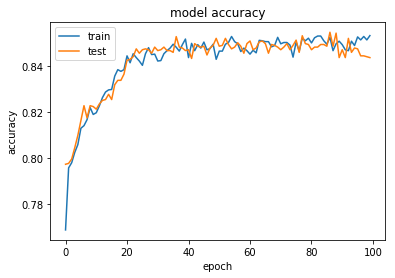

In [42]:
# list all data in history
print(model_history.history.keys())
# summarize history for accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

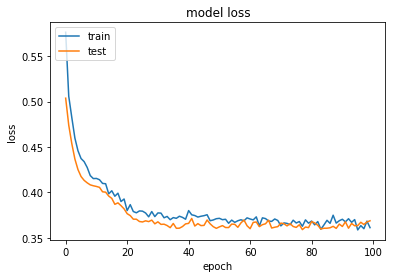

In [43]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Part 3 - Making the predictions and evaluating the model**

In [0]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [45]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1578,   17],
       [ 278,  127]])

In [46]:
# Calculate the Accuracy
from sklearn.metrics import accuracy_score
score=accuracy_score(y_pred,y_test)
print('The score accuracy is: %0.2f%%' %(score*100))

The score accuracy is: 85.25%


**Conclusions:**

From the above Machine Learning classifiers and ANN, it's clear that Random Forest Classifier performed best with accuracy > 87%. This is good but can we use Machine Leanring in this? Well a useful application i can come up with is building a churn predictor. That is, given customer information, predict how likely he/she is likely to churn in the next month. But...


**NB:** 
> Although i have performed ML and ANN on this dataset, the data provided is not enough to justify using predictive modeling. I would need customer behavior over time such as:
>>1.   Where were they before joining the bank?
2.   When did they join us?

> We could extract features and throw it into an ML or ANN model but since we only have one tuple per customer, building this classier isn't really helpful given this data.